In [1]:
import os
os.chdir("../../")

In [2]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [3]:
try:
    from probml_utils import latexify,is_latexify_enabled,savefig
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify,is_latexify_enabled,savefig

In [4]:
from flax import linen as nn
from flax.core import unfreeze
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
from models.gaussian_mlp import gmlp
from models.mlp import mlp
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

import tensorflow_probability.substrates.jax as tfp

import pandas as pd

# jax.config.update("jax_enable_x64", True)

In [5]:
dist = tfp.distributions

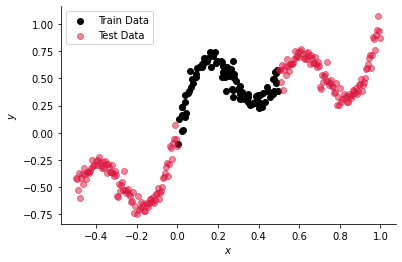

In [6]:
X, y, x_test, y_test = sin_data.load_data()
plot.plot_actualdata(X, y, x_test, y_test)

In [7]:
def loss_fn(mean, sigma, y):
    d = dist.Normal(loc=mean, scale=sigma)
    return -d.log_prob(y)

## MLP

In [8]:
mlp_model = mlp([32, 32, 1], [nn.relu, nn.relu], [0, 0])

In [9]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [10]:
auxs = {"X": X, "y": y, "deterministic": True}

In [11]:
mlp_params, mlp_loss = fit(
    mlp_model,
    mlp_params,
    X,
    y,
    deterministic=True,
    batch_size=len(X),
    learning_rate=0.01,
    epochs=2000,
)

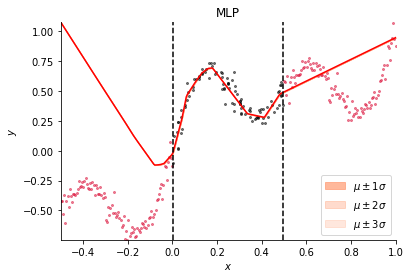

In [12]:
x_linspace = jnp.linspace(-0.5, 1, 300).reshape(-1, 1)
n_points = 300
y_hat = mlp_model.apply(mlp_params, x_linspace, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction_reg(X, y, x_test, y_test, x_linspace, y_hat, 0, "MLP")
# plt.savefig("figures/mlp_sinData",bbox_inches="tight")

In [36]:
mlp_loss_train = mlp_model.loss_fn(mlp_params, X, y, True)
mlp_loss_test = mlp_model.loss_fn(mlp_params, x_test, y_test, True)


Gaussian MLP

In [14]:
gmlp_model = gmlp(
    features=[16, 16], activations=[nn.relu, nn.relu], dropout_rate=[0.01, 0.01]
)

In [15]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [16]:
gmlp_params, loss = fit(
    gmlp_model,
    gmlp_params,
    X,
    y,
    deterministic=True,
    batch_size=len(X),
    learning_rate=0.003,
    epochs=2000,
    rng=jax.random.PRNGKey(11),
)

In [17]:
gmlp_train_loss = gmlp_model.loss_fn(gmlp_params, X, y, True, jax.random.PRNGKey(0))
gmlp_test_loss =  gmlp_model.loss_fn(gmlp_params, x_test, y_test, True, jax.random.PRNGKey(0))

In [18]:
gmlp_train_loss, gmlp_test_loss

(DeviceArray(-1.3865759, dtype=float32), DeviceArray(1.4941483, dtype=float32))

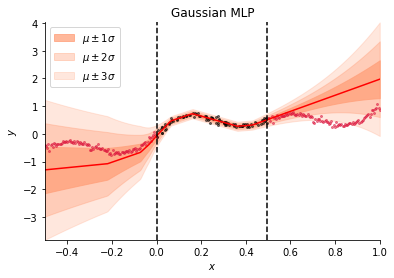

In [19]:
x_linspace = jnp.linspace(-0.5, 1, 300).reshape(-1, 1)
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_linspace, True)
gmlp_train_mean, gmlp_train_sigma = gmlp_model.apply(gmlp_params, X, True)
gmlp_test_mean, gmlp_test_sigma = gmlp_model.apply(gmlp_params, x_test, True)
gmlp_mean, gmlp_sigma = gmlp_mean.reshape(n_points), gmlp_sigma.reshape(n_points)
plot.plot_prediction_reg(
    X, y, x_test, y_test, x_linspace, gmlp_mean, gmlp_sigma, "Gaussian MLP"
)
# plt.savefig("figures/gmlp_sinData",bbox_inches="tight")

## MC Dropout Gaussian MLP

In [20]:
n_stacks = 100
fn = lambda x, i: gmlp_model.apply(
    gmlp_params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)}
)
y_stacks = jax.vmap(fn, in_axes=(None, 0))(x_linspace, jnp.arange(n_stacks))
y_test_stacks = jax.vmap(fn, in_axes=(None, 0))(x_test, jnp.arange(n_stacks))
y_train_stacks = jax.vmap(fn, in_axes=(None, 0))(X, jnp.arange(n_stacks))

In [21]:
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]
mean_train_stacks = y_train_stacks[0]
sigma_train_stacks = y_train_stacks[1]
mean_test_stacks = y_test_stacks[0]
sigma_test_stacks = y_test_stacks[1]

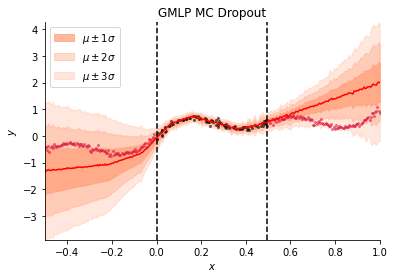

In [22]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)
mc_train_mean, mc_train_sigma = gmm_mean_var(mean_train_stacks, sigma_train_stacks)
mc_test_mean, mc_test_sigma = gmm_mean_var(mean_test_stacks, sigma_test_stacks)
mc_mean, mc_sigma = mc_mean.reshape(n_points), mc_sigma.reshape(n_points)
plot.plot_prediction_reg(
    X, y, x_test, y_test, x_linspace, mc_mean, mc_sigma, "GMLP MC Dropout"
)
# plt.savefig("figures/gmlp_mcDropout_sinData",bbox_inches="tight")

In [23]:
mc_loss_train = jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mc_train_mean, mc_train_sigma, y))
mc_loss_test = jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mc_test_mean, mc_test_sigma, y_test))

In [24]:
mc_loss_train, mc_loss_test

(DeviceArray(-1.3001596, dtype=float32), DeviceArray(1.2217234, dtype=float32))

## Deep Ensemble Gaussian MLP

In [25]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), X, deterministic=True)
    params, loss = fit(
        gmlp_model,
        params,
        X,
        y,
        True,
        batch_size=len(X),
        learning_rate=0.003,
        epochs=2000,
    )
    params_list.append(params)
    losses_list.append(loss)

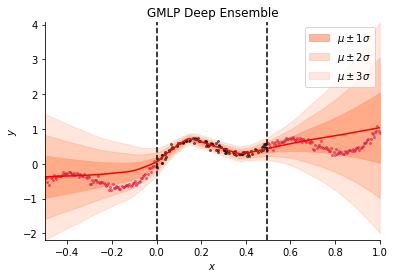

In [26]:
mean_list, sigma_list = predict(n_models, gmlp_model, params_list, x_linspace)
mean_train_list, sigma_train_list = predict(n_models, gmlp_model, params_list, X)
mean_test_list, sigma_test_list = predict(n_models, gmlp_model, params_list, x_test)

de_mean, de_sigma = gmm_mean_var(mean_list, sigma_list)
de_train_mean, de_train_sigma = gmm_mean_var(mean_train_list, sigma_train_list)
de_test_mean, de_test_sigma = gmm_mean_var(mean_test_list, sigma_test_list)

de_mean, de_sigma = de_mean.reshape(n_points), de_sigma.reshape(n_points)
plot.plot_prediction_reg(
    X, y, x_test, y_test, x_linspace, de_mean, de_sigma, "GMLP Deep Ensemble"
)
# plt.savefig("figures/gmlp_ensemble_sinData",bbox_inches="tight")

In [27]:
de_loss_train = jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(de_train_mean, de_train_sigma, y))
de_loss_test = jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(de_test_mean, de_test_sigma, y_test))
de_loss_train, de_loss_test

(DeviceArray(-1.2921988, dtype=float32), DeviceArray(0.2474683, dtype=float32))

## GP

In [28]:
key = jax.random.PRNGKey(42)
sigmaf = 1.0
len_scale = 1.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)
%%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False)
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp = mu_gp.reshape(n_points)
sigma_gp = jnp.sqrt(cov_gp).reshape(n_points)

UsageError: Line magic function `%%capture` not found.


In [29]:
%%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False)
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)

In [30]:
%%capture
mu_gp, cov_gp = model_gp.predict(x_linspace)
mu_gp = mu_gp.reshape(n_points)
sigma_gp = jnp.sqrt(cov_gp).reshape(n_points)

In [31]:
mu_gp_1, cov_gp_1 = model_gp.predict(X)
mu_gp_2, cov_gp_2 = model_gp.predict(x_test)

In [32]:
def loss_calcc3(mean, sigma, y):
    def loss_calc(mean, sigma, y):
        d = dist.Normal(loc=mean, scale=sigma)
        return -d.prob(y)

    return jnp.mean(jax.vmap(loss_calc, in_axes=(0, 0, 0))(mean, sigma, y))

In [33]:
l1 = loss_calcc3(mu_gp_1, jnp.sqrt(cov_gp_1), y)
l2 = loss_calcc3(mu_gp_2, jnp.sqrt(cov_gp_2), y_test)
l1, l2

(DeviceArray(-4.35115, dtype=float32), DeviceArray(-0.9701789, dtype=float32))

In [34]:
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False)
gp_train_loss = model_gp.log_likelihood()
gp_train_loss
# model_test = GPy.models.GPRegression(x_test, y_test, kernel, normalizer=False)
# model_test.log_likelihood() (edited)

DeviceArray(-97.424644, dtype=float32)

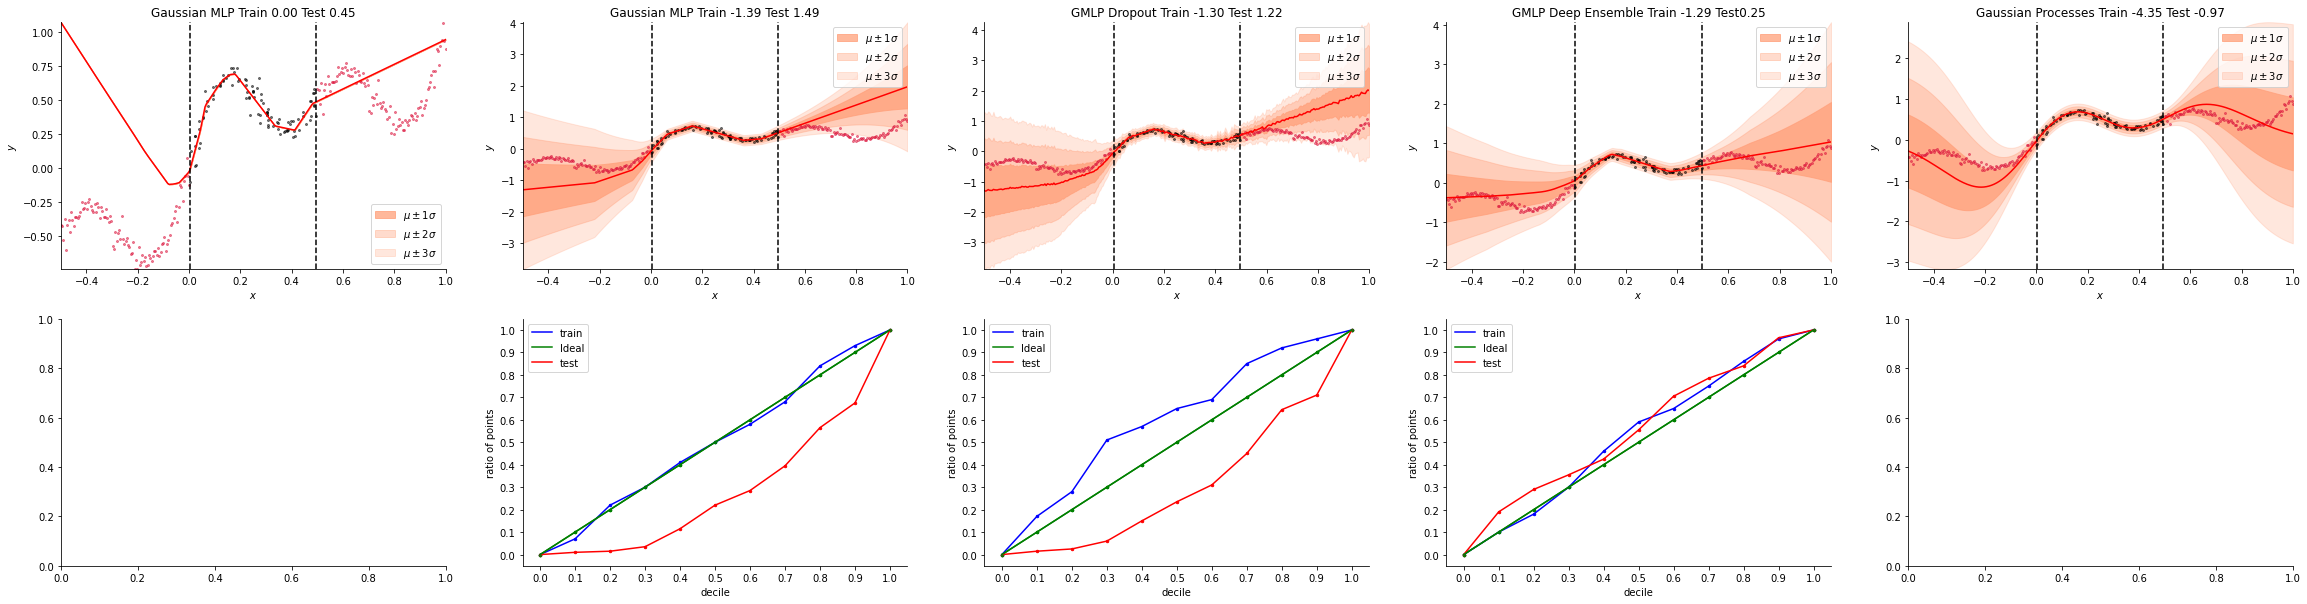

In [37]:
fig, ax = plt.subplots(2, 5, figsize=(40, 10))
plot.plot_prediction_reg(
    X,
    y,
    x_test,
    y_test,
    x_linspace,
    y_hat,
    0,
    f"Gaussian MLP Train {mlp_loss_train:.2f} Test {mlp_loss_test:.2f}",
    ax[0][0],
)
plot.plot_prediction_reg(
    X,
    y,
    x_test,
    y_test,
    x_linspace,
    gmlp_mean,
    gmlp_sigma,
    f"Gaussian MLP Train {gmlp_train_loss:.2f} Test {gmlp_test_loss:.2f}",
    ax[0][1],
)
plot.plot_prediction_reg(
    X,
    y,
    x_test,
    y_test,
    x_linspace,
    mc_mean,
    mc_sigma,
    f"GMLP Dropout Train {mc_loss_train:.2f} Test {mc_loss_test:.2f}",
    ax[0][2],
)
plot.plot_prediction_reg(
    X,
    y,
    x_test,
    y_test,
    x_linspace,
    de_mean,
    de_sigma,
    f"GMLP Deep Ensemble Train {de_loss_train:.2f} Test{de_loss_test:.2f}",
    ax[0][3],
)
plot.plot_prediction_reg(
    X,
    y,
    x_test,
    y_test,
    x_linspace,
    mu_gp,
    sigma_gp,
    f"Gaussian Processes Train {l1:.2f} Test {l2:.2f}",
    ax[0][4],
)
_=plot.calibration_regression(gmlp_train_mean, gmlp_train_sigma, y, "train", "blue", ax[1][1])
_=plot.calibration_regression(gmlp_test_mean, gmlp_test_sigma, y_test, "test", "red", ax[1][1])

_=plot.calibration_regression(mc_train_mean, mc_train_sigma, y, "train", "blue", ax[1][2])
_=plot.calibration_regression(mc_test_mean, mc_test_sigma, y_test, "test", "red", ax[1][2])

_=plot.calibration_regression(de_train_mean, de_train_sigma, y, "train", "blue", ax[1][3])
_=plot.calibration_regression(de_test_mean, de_test_sigma, y_test, "test", "red", ax[1][3])

# plot.calibration_reg(mu_gp, sigma_gp, y_test, ax[1][4])
# plt.savefig('SinData.pdf')